<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/01_clustering_fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clustering Fundamental

Although most of the applications of Machine Learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features $X$, but we do not have the labels $y$.

In this notebook we will look at a few more unsupervised learning tasks
and algorithms:

* **Clustering**-The goal is to group similar instances together into clusters.
* **Anomaly detection**-The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances.
* **Density estimation**-This is the task of estimating the probability density function (PDF) of the random process that generated the dataset.

There is no universal definition of what a cluster is: it really depends on the context,
and different algorithms will capture different kinds of clusters. 

Some algorithms look for instances centered around a particular point, called a centroid. 

Others look for continuous regions of densely packed instances: these clusters can take on any shape. 

Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

There are two popular clustering algorithms:

* **K-Means**
* **DBSCAN**

And these are the some of their applications, such as nonlinear dimensionality
reduction, semi-supervised learning, and anomaly detection.

##Setup

In [1]:
# Common imports
import numpy as np
import os
from timeit import timeit

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy.stats import norm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's load iris dataset.

In [2]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [10]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [18]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

##Clustering

The clustering is the task of identifying similar instances and assigning
them to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification,
clustering is an unsupervised task.



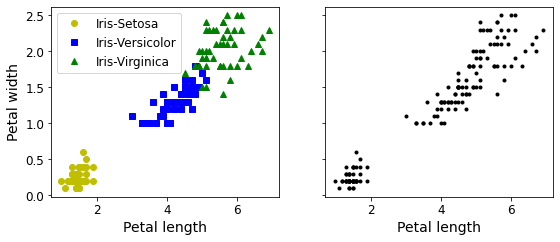

In [3]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

On the right is the same dataset, but without the labels, so you cannot use a
classification algorithm anymore. 

This is where clustering algorithms step in: many of
them can easily detect the lower-left cluster. 

It is also quite easy to see with our own
eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.

But the dataset has two additional features (sepal length and
width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well.

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).



In [4]:
y_pred= GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

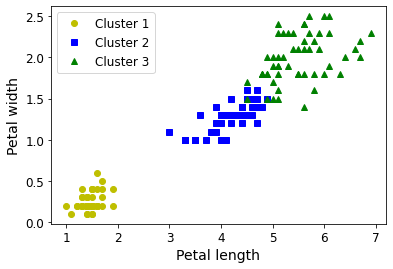

In [5]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

And using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster.

In [6]:
np.sum(y_pred==y)

145

In [7]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

##K-Means

The K-Means algorithm is a simple algorithm capable of clustering
the unlabeled dataset very quickly and efficiently, often in just a few iterations.



In [8]:
blob_centers = np.array([
    [ 0.2,  2.3],
    [-1.5 ,  2.3],
    [-2.8,  1.8],
    [-2.8,  2.8],
    [-2.8,  1.3]                     
])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [9]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=42)

Now let's plot them:

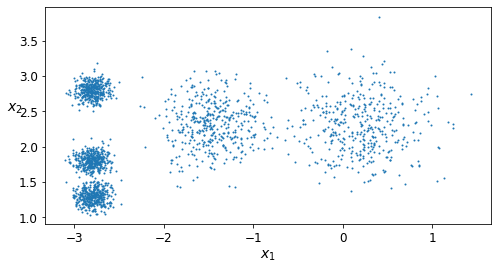

In [11]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

plt.show()

Let’s train a K-Means clusterer on this dataset. 

It will try to find each blob’s center and assign each instance to the closest blob:

In [12]:
k = 5

kmeans = KMeans(n_clusters=5, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the five clusters. 

In the context of clustering, an
instance’s label is the index of the cluster that this instance gets assigned to by the
algorithm: this is not to be confused with the class labels in classification (remember
that clustering is an unsupervised learning task). 

The KMeans instance preserves a
copy of the labels of the instances it was trained on, available via the `labels_` instance variable:

In [13]:
y_pred

array([2, 1, 3, ..., 1, 2, 4], dtype=int32)

In [15]:
y_pred is kmeans.labels_

True

We can also take a look at the five centroids that the algorithm found:

In [16]:
kmeans.cluster_centers_

array([[-2.79244799,  1.2973862 ],
       [ 0.20925539,  2.30351618],
       [-2.79846237,  2.80004584],
       [-1.4453407 ,  2.32051326],
       [-2.80372723,  1.80873739]])

You can easily assign new instances to the cluster whose centroid is closest:

In [17]:
x_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(x_new)

array([1, 1, 2, 2], dtype=int32)

If you plot the cluster’s decision boundaries, you get a Voronoi tessellation (where each centroid is represented with an X).

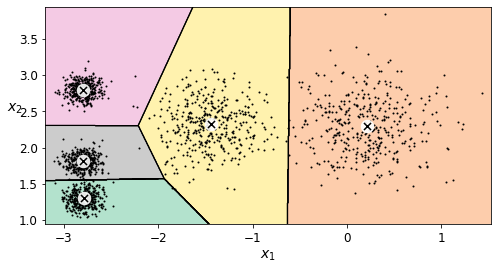

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but
a few instances were probably mislabeled (especially near the boundary between the
top-left cluster and the central cluster).

Indeed, the K-Means algorithm does not
behave very well when the blobs have very different diameters because all it cares
about when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called hard clustering, it
can be useful to give each instance a score per cluster, which is called soft clustering.
The score can be the distance between the instance and the centroid; conversely, it
can be a similarity score (or affinity), such as the Gaussian Radial Basis Function.

In the KMeans class, the `transform()` method measures
the distance from each instance to every centroid:

In [20]:
kmeans.transform(x_new)

array([[2.87948466, 0.36865958, 2.91057812, 1.48045212, 2.81024337],
       [5.8349053 , 2.80720102, 5.85339553, 4.45688037, 5.80687792],
       [1.71521765, 3.28396253, 0.28389977, 1.69666372, 1.20732332],
       [1.22039247, 3.21526454, 0.36144837, 1.56498595, 0.7185868 ]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [21]:
np.linalg.norm(np.tile(x_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.87948466, 0.36865958, 2.91057812, 1.48045212, 2.81024337],
       [5.8349053 , 2.80720102, 5.85339553, 4.45688037, 5.80687792],
       [1.71521765, 3.28396253, 0.28389977, 1.69666372, 1.20732332],
       [1.22039247, 3.21526454, 0.36144837, 1.56498595, 0.7185868 ]])

If you have a high-dimensional
dataset and you transform it this way, you end up with a `k-dimensional` dataset: this
transformation can be a very efficient nonlinear dimensionality reduction technique.

###The K-Means algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [22]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=1, random_state=42)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=2, random_state=42)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=3, random_state=42)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=42)

And let's plot this:

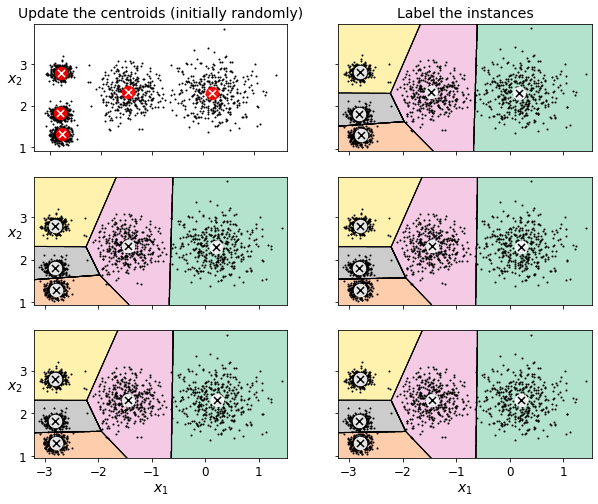

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

You can see the algorithm in action, the centroids are initialized randomly
(top left), then the instances are labeled (top right), then the centroids are
updated (center left), the instances are relabeled (center right), and so on. 

As you can
see, in just three iterations, the algorithm has reached a clustering that seems close to
optimal.

Although the algorithm is guaranteed to converge, it may not converge to the right
solution (i.e., it may converge to a local optimum): whether it does or not depends on
the centroid initialization.

###Centroid initialization methods